In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer,LabelEncoder
from sklearn.metrics import mean_squared_error,f1_score
from sklearn.kernel_approximation import Nystroem

from sklearn.model_selection import StratifiedKFold

from catboost import Pool, cv,CatBoostClassifier,CatBoostRegressor

from tqdm import tqdm

from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN

In [9]:
train_df = pd.read_csv('train_df.csv')
train_df = train_df.fillna(0)
test_df = pd.read_csv('test_df.csv')
test_df = test_df.fillna(0)
submission_df = pd.read_csv('sample_submission.csv')

In [10]:
y = train_df['label'].values
y.sum()/y.shape[0]

0.9100607060765015

In [11]:
sampling_strategy = 0.125

ros = RandomOverSampler(random_state=0,sampling_strategy=sampling_strategy)
train_df,y = ros.fit_resample(train_df,y)

In [12]:
y.sum()/y.shape[0]

0.8888952852455242

In [13]:
data = train_df[train_df['label'] == 1].dropna()

In [14]:
params = {
    'loss_function':'RMSE',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'RMSE'
}

# Fare

In [15]:
train_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_date,pickup_hour,pickup_minute,drop_date,...,drop_minute,pick_cluster,is_more_than_one_day,distance_km,fare_per_km,pickup_timeslot,day_of_week,is_weekday,cal_time_difference,label
0,10.5,834.0,56.0,0.0000,64.0,270.32,1,0,20,1,...,34,0,0,5.072065,53.190982,0,4,1,6.0,1
1,10.5,791.0,47.0,0.0000,134.0,197.85,1,0,56,1,...,9,0,0,3.151780,62.575517,0,4,1,-11.0,1
2,10.5,1087.0,80.0,0.0000,61.0,301.64,1,1,8,1,...,26,0,0,6.302418,47.785178,0,4,1,-7.0,1
3,10.5,598.0,271.0,15.6638,68.0,82.30,1,2,27,1,...,37,0,0,0.862654,94.309954,0,4,1,2.0,1
4,10.5,3407.0,182.0,0.0000,112.0,1065.02,1,5,38,1,...,35,3,0,24.078955,44.211964,3,4,1,13.0,1


In [16]:
train_df.corr()['fare']

additional_fare              0.290594
duration                     0.878046
meter_waiting                0.879703
meter_waiting_fare           0.875426
meter_waiting_till_pickup    0.046309
fare                         1.000000
pickup_date                  0.017804
pickup_hour                 -0.010341
pickup_minute                0.005529
drop_date                    0.010641
drop_hour                    0.000239
drop_minute                 -0.005613
pick_cluster                 0.027478
is_more_than_one_day         0.427502
distance_km                  0.327969
fare_per_km                  0.160005
pickup_timeslot              0.021058
day_of_week                  0.003968
is_weekday                  -0.001991
cal_time_difference         -0.778249
label                       -0.185599
Name: fare, dtype: float64

In [17]:
cols = ['duration','meter_waiting','meter_waiting_fare','is_more_than_one_day']

In [18]:
X = data[cols].values
y = data['fare'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [20]:
folds = 3

In [21]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))

    model = LinearRegression()
#     model = SVR()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 96.5273471319087
RMSE: 82.29682215032592
RMSE: 82.63358797352826


In [22]:
np.mean(validation_scores)

87.15258575192097

In [23]:
train_df['predicted_fare'] = train_preds
test_df['predicted_fare'] = test_preds

In [24]:
train_df['predicted_fare_diff'] = train_df['fare'] - train_df['predicted_fare']
test_df['predicted_fare_diff'] = test_df['fare'] - test_df['predicted_fare']    

In [25]:
train_df['predicted_fare_diff_per_fare'] = train_df['predicted_fare_diff'] / (train_df['fare']+1)
test_df['predicted_fare_diff_per_fare'] = test_df['predicted_fare_diff'] / (test_df['fare']+1)

In [26]:
train_df['predicted_fare_diff_per_predicted_fare'] = train_df['predicted_fare_diff'] / (train_df['predicted_fare']+1)
test_df['predicted_fare_diff_per_predicted_fare'] = test_df['predicted_fare_diff'] / (test_df['predicted_fare']+1)

In [27]:
train_df['fare_per_distance'] = train_df['fare'] / (train_df['distance_km']+1)
test_df['fare_per_distance'] = test_df['fare'] / (test_df['distance_km']+1)

In [28]:
train_df['predicted_fare_per_distance'] = train_df['predicted_fare'] / (train_df['distance_km']+1)
test_df['predicted_fare_per_distance'] = test_df['predicted_fare'] / (test_df['distance_km']+1)

In [29]:
train_df['predicted_fare_diff_per_distance'] = train_df['predicted_fare_diff'] / (train_df['distance_km']+1)
test_df['predicted_fare_diff_per_distance'] = test_df['predicted_fare_diff'] / (test_df['distance_km']+1)

In [30]:
train_df['predicted_fare_diff_per_fare'] = train_df['predicted_fare_diff'] / (train_df['fare']+1)
test_df['predicted_fare_diff_per_fare'] = test_df['predicted_fare_diff'] / (test_df['fare']+1)

# Duration

In [31]:
train_df.corr()['duration']

additional_fare                          -0.000964
duration                                  1.000000
meter_waiting                             0.975018
meter_waiting_fare                        0.974123
meter_waiting_till_pickup                 0.039087
fare                                      0.878046
pickup_date                               0.010524
pickup_hour                              -0.008698
pickup_minute                             0.005247
drop_date                                 0.001361
drop_hour                                -0.007428
drop_minute                              -0.004126
pick_cluster                              0.002146
is_more_than_one_day                      0.453779
distance_km                               0.123519
fare_per_km                               0.067244
pickup_timeslot                           0.002462
day_of_week                              -0.004771
is_weekday                                0.004256
cal_time_difference            

In [32]:
cols = ['meter_waiting','meter_waiting_fare','fare','is_more_than_one_day','cal_time_difference']

In [33]:
X = data[cols].values
y = data['duration'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [35]:
folds = 3

In [36]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 412.05683862976997
RMSE: 332.70147883644177
RMSE: 343.7877005393285


In [37]:
np.mean(validation_scores)

362.8486726685134

In [38]:
train_df['predicted_duration'] = train_preds
test_df['predicted_duration'] = test_preds

In [39]:
train_df['predicted_duration_diff'] = train_df['duration'] - train_df['predicted_duration']
test_df['predicted_duration_diff'] = test_df['duration'] - test_df['predicted_duration']    

In [40]:
train_df['predicted_duraton_diff_per_duraton'] = train_df['predicted_duration_diff'] / (train_df['duration']+1)
test_df['predicted_duraton_diff_per_duraton'] = test_df['predicted_duration_diff'] / (test_df['duration']+1)

In [41]:
train_df['predicted_duraton_diff_per_predicted_duration'] = train_df['predicted_duration_diff'] / (train_df['predicted_duration']+1)
test_df['predicted_duraton_diff_per_predicted_duration'] = test_df['predicted_duration_diff'] / (test_df['predicted_duration']+1)

In [42]:
train_df['predicted_duraton_diff_per_distance'] = train_df['predicted_duration_diff'] / (train_df['distance_km']+1)
test_df['predicted_duraton_diff_per_distance'] = test_df['predicted_duration_diff'] / (test_df['distance_km']+1)

In [43]:
train_df['fare_per_duration'] = train_df['fare'] / (train_df['duration']+1)
test_df['fare_per_duration'] = test_df['fare'] / (test_df['duration']+1)

In [44]:
train_df['predicted_fare_per_duration'] = train_df['predicted_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_fare_per_duration'] = test_df['predicted_fare'] / (test_df['predicted_duration']+1)

In [45]:
train_df['predicted_fare_per_duration_diff'] = train_df['fare_per_duration'] - train_df['predicted_fare_per_duration']
test_df['predicted_fare_per_duration_diff'] = test_df['fare_per_duration'] - test_df['predicted_fare_per_duration']

In [46]:
train_df['avg_speed'] = train_df['distance_km'] / (train_df['duration'] + 1)
test_df['avg_speed'] = test_df['distance_km'] / (test_df['duration'] + 1)

In [47]:
train_df['predicted_avg_speed'] = train_df['distance_km'] / (train_df['predicted_duration'] + 1)
test_df['predicted_avg_speed'] = test_df['distance_km'] / (test_df['predicted_duration'] + 1)

In [48]:
train_df['predicted_avg_speed_diff'] = train_df['avg_speed'] - train_df['predicted_avg_speed']
test_df['predicted_avg_speed_diff'] = test_df['avg_speed'] - test_df['predicted_avg_speed']    

# Meter waiting

In [49]:
train_df.corr()['meter_waiting']

additional_fare                                  0.177489
duration                                         0.975018
meter_waiting                                    1.000000
meter_waiting_fare                               0.999558
meter_waiting_till_pickup                        0.029673
fare                                             0.879703
pickup_date                                      0.006888
pickup_hour                                     -0.011257
pickup_minute                                    0.005565
drop_date                                       -0.002084
drop_hour                                       -0.016529
drop_minute                                     -0.003734
pick_cluster                                     0.002636
is_more_than_one_day                             0.438264
distance_km                                      0.044016
fare_per_km                                      0.048883
pickup_timeslot                                  0.008809
day_of_week   

In [50]:
cols = ['duration','meter_waiting_fare','fare','cal_time_difference']

In [51]:
X = data[cols].values
y = data['meter_waiting'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [53]:
folds = 3

In [54]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 121.23549829752587
RMSE: 126.15607547905648
RMSE: 119.87616226350285


In [55]:
np.mean(validation_scores)

122.4225786800284

In [56]:
train_df['predicted_meter_waiting'] = train_preds
test_df['predicted_meter_waiting'] = test_preds

In [57]:
train_df['predicted_meter_waiting_diff'] = train_df['meter_waiting'] - train_df['predicted_meter_waiting']
test_df['predicted_meter_waiting_diff'] = test_df['meter_waiting'] - test_df['predicted_meter_waiting']

In [58]:
train_df['predicted_meter_waiting_diff_per_meter_waiting'] = train_df['predicted_meter_waiting_diff'] / (train_df['meter_waiting'] + 1)
test_df['predicted_meter_waiting_diff_per_meter_waiting'] = test_df['predicted_meter_waiting_diff'] / (test_df['meter_waiting'] + 1)

In [59]:
train_df['predicted_meter_waiting_diff_per_distance'] = train_df['predicted_meter_waiting_diff'] / (train_df['distance_km'] + 1)
test_df['predicted_meter_waiting_diff_per_distance'] = test_df['predicted_meter_waiting_diff'] / (test_df['distance_km'] + 1)

In [60]:
train_df['predicted_meter_waiting_diff_per_predicted_meter_waiting'] = train_df['predicted_meter_waiting_diff'] / (train_df['predicted_meter_waiting'] + 1)
test_df['predicted_meter_waiting_diff_per_predicted_meter_waiting'] = test_df['predicted_meter_waiting_diff'] / (test_df['predicted_meter_waiting'] + 1)

In [61]:
train_df['meter_waiting_per_duration'] = train_df['meter_waiting'] / (train_df['duration']+1)
test_df['meter_waiting_per_duration'] = test_df['meter_waiting'] / (test_df['duration']+1)

In [62]:
train_df['predicted_meter_waiting_per_duration'] = train_df['predicted_meter_waiting'] / (train_df['predicted_duration']+1)
test_df['predicted_meter_waiting_per_duration'] = test_df['predicted_meter_waiting'] / (test_df['predicted_duration']+1)

In [63]:
train_df['predicted_meter_waiting_per_duration_diff'] = train_df['meter_waiting_per_duration'] - train_df['predicted_meter_waiting_per_duration']
test_df['predicted_meter_waiting_per_duration_diff'] = test_df['meter_waiting_per_duration'] - test_df['predicted_meter_waiting_per_duration']

# Meter waiting fare

In [64]:
train_df.corr()['meter_waiting_fare']

additional_fare                                             0.179283
duration                                                    0.974123
meter_waiting                                               0.999558
meter_waiting_fare                                          1.000000
meter_waiting_till_pickup                                   0.029154
fare                                                        0.875426
pickup_date                                                 0.006413
pickup_hour                                                -0.010668
pickup_minute                                               0.005400
drop_date                                                  -0.002599
drop_hour                                                  -0.016076
drop_minute                                                -0.003515
pick_cluster                                                0.003534
is_more_than_one_day                                        0.436440
distance_km                       

In [65]:
cols = ['duration','meter_waiting','fare','is_more_than_one_day','cal_time_difference']

In [66]:
X = data[cols].values
y = data['meter_waiting_fare'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [67]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [68]:
folds = 3

In [69]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
   
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 7.21561205286957
RMSE: 7.758602065112114
RMSE: 8.8391720955996


In [70]:
np.mean(validation_scores)

7.937795404527095

In [71]:
train_df['predicted_meter_waiting_fare'] = train_preds
test_df['predicted_meter_waiting_fare'] = test_preds

In [72]:
train_df['predicted_meter_waiting_fare_diff'] = train_df['meter_waiting_fare'] - train_df['predicted_meter_waiting_fare']
test_df['predicted_meter_waiting_fare_diff'] = test_df['meter_waiting_fare'] - test_df['predicted_meter_waiting_fare']

In [73]:
train_df['predicted_meter_waiting_fare_diff_per_meter_waiting_fare'] = train_df['predicted_meter_waiting_fare_diff'] / (train_df['meter_waiting_fare']+1)
test_df['predicted_meter_waiting_fare_diff_per_meter_waiting_fare'] = test_df['predicted_meter_waiting_fare_diff'] / (test_df['meter_waiting_fare']+1)

In [74]:
train_df['predicted_meter_waiting_fare_diff_per_distance'] = train_df['predicted_meter_waiting_fare_diff'] / (train_df['distance_km']+1)
test_df['predicted_meter_waiting_fare_diff_per_distance'] = test_df['predicted_meter_waiting_fare_diff'] / (test_df['distance_km']+1)

In [75]:
train_df['predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare'] = train_df['predicted_meter_waiting_fare_diff'] / (train_df['predicted_meter_waiting_fare']+1)
test_df['predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare'] = test_df['predicted_meter_waiting_fare_diff'] / (test_df['predicted_meter_waiting_fare']+1)

In [76]:
train_df['meter_waiting_fare_per_meter_waiting'] = train_df['meter_waiting_fare'] / train_df['meter_waiting']
test_df['meter_waiting_fare_per_meter_waiting'] = test_df['meter_waiting_fare'] / test_df['meter_waiting']

In [77]:
train_df['predicted_meter_waiting_fare_per_meter_waiting'] = train_df['predicted_meter_waiting_fare'] / train_df['predicted_meter_waiting']
test_df['predicted_meter_waiting_fare_per_meter_waiting'] = test_df['predicted_meter_waiting_fare'] / test_df['predicted_meter_waiting']

In [78]:
train_df['predicted_meter_waiting_fare_per_meter_waiting_diff'] = train_df['meter_waiting_fare_per_meter_waiting'] - train_df['predicted_meter_waiting_fare_per_meter_waiting']
test_df['predicted_meter_waiting_fare_per_meter_waiting_diff'] = test_df['meter_waiting_fare_per_meter_waiting'] - test_df['predicted_meter_waiting_fare_per_meter_waiting']

In [79]:
train_df['meter_waiting_fare_per_duration'] = train_df['meter_waiting_fare'] / train_df['duration']
test_df['meter_waiting_fare_per_duration'] = test_df['meter_waiting_fare'] / test_df['duration']

In [80]:
train_df['predicted_meter_waiting_fare_per_duration'] = train_df['predicted_meter_waiting_fare'] / train_df['predicted_duration']
test_df['predicted_meter_waiting_fare_per_duration'] = test_df['predicted_meter_waiting_fare'] / test_df['predicted_duration']

In [81]:
train_df['predicted_meter_waiting_fare_per_duration_diff'] = train_df['meter_waiting_fare_per_duration'] - train_df['predicted_meter_waiting_fare_per_duration']
test_df['predicted_meter_waiting_fare_per_duration_diff'] = test_df['meter_waiting_fare_per_duration'] - test_df['predicted_meter_waiting_fare_per_duration']

# Addtional fare

In [82]:
train_df.corr()['additional_fare']

additional_fare                                                       1.000000
duration                                                             -0.000964
meter_waiting                                                         0.177489
meter_waiting_fare                                                    0.179283
meter_waiting_till_pickup                                             0.002359
fare                                                                  0.290594
pickup_date                                                           0.006677
pickup_hour                                                          -0.003907
pickup_minute                                                        -0.000585
drop_date                                                             0.006691
drop_hour                                                            -0.003559
drop_minute                                                           0.000416
pick_cluster                                        

In [83]:
cols = ['meter_waiting_fare_per_duration','meter_waiting_per_duration','fare_per_duration']

In [84]:
data = train_df[train_df['label'] == 1].dropna()

In [85]:
X = data[cols].values
y = data['additional_fare'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [86]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = np.nan_to_num(scaler.transform(X_train_df))
X_test_df = np.nan_to_num(scaler.transform(X_test_df))

In [87]:
folds = 3

In [88]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
   
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 8.720292350311684
RMSE: 11.875141951981368
RMSE: 12.088516557325503


In [89]:
train_df['predicted_additional_fare'] = train_preds
test_df['predicted_additional_fare'] = test_preds

In [90]:
train_df['predicted_additional_fare_diff'] = train_df['additional_fare'] - train_df['predicted_additional_fare']
test_df['predicted_additional_fare_diff'] = test_df['additional_fare'] - test_df['predicted_additional_fare']

In [91]:
train_df['predicted_additional_fare_diff_per_additional_fare'] = train_df['predicted_additional_fare_diff'] / (train_df['additional_fare']+1)
test_df['predicted_additional_fare_diff_per_additional_fare'] = test_df['predicted_additional_fare_diff'] / (test_df['additional_fare']+1)

In [92]:
train_df['predicted_addtional_fare_per_fare'] = train_df['predicted_additional_fare'] / (train_df['predicted_fare']+1)
test_df['predicted_addtional_fare_per_fare'] = test_df['predicted_additional_fare'] / (test_df['predicted_fare']+1)

In [93]:
train_df['addtional_fare_per_fare'] = train_df['additional_fare'] / (train_df['fare']+1)
test_df['addtional_fare_per_fare'] = test_df['additional_fare'] / (test_df['fare']+1)

In [94]:
train_df['addtional_fare_per_distance'] = train_df['additional_fare'] / (train_df['distance_km']+1)
test_df['addtional_fare_per_distance'] = test_df['additional_fare'] / (test_df['distance_km']+1)

In [95]:
train_df['predicted_addtional_fare_per_distance'] = train_df['predicted_additional_fare'] / (train_df['distance_km']+1)
test_df['predicted_addtional_fare_per_distance'] = test_df['predicted_additional_fare'] / (test_df['distance_km']+1)

In [96]:
train_df['predicted_addtional_fare_diff_per_distance'] = train_df['predicted_additional_fare_diff'] / (train_df['distance_km']+1)
test_df['predicted_addtional_fare_diff_per_distance'] = test_df['predicted_additional_fare_diff'] / (test_df['distance_km']+1)

In [97]:
train_df['addtional_fare_per_duration'] = train_df['additional_fare'] / (train_df['duration']+1)
test_df['addtional_fare_per_duration'] = test_df['additional_fare'] / (test_df['duration']+1)

In [98]:
train_df['predicted_addtional_fare_per_duration'] = train_df['predicted_additional_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_addtional_fare_per_duration'] = test_df['predicted_additional_fare'] / (test_df['predicted_duration']+1)

In [99]:
train_df['fare-additional_fare'] = train_df['fare'] - train_df['additional_fare']
test_df['fare-additional_fare'] = test_df['fare'] - test_df['additional_fare']

In [100]:
train_df['predicted_fare-additional_fare'] = train_df['predicted_fare'] - train_df['predicted_additional_fare']
test_df['predicted_fare-additional_fare'] = test_df['predicted_fare'] - test_df['predicted_additional_fare']

In [101]:
train_df['fare-additional_fare-meter_waiting_fare'] = train_df['fare'] - (train_df['additional_fare'] + train_df['meter_waiting_fare'])
test_df['fare-additional_fare-meter_waiting_fare'] = test_df['fare'] - (test_df['additional_fare'] + test_df['meter_waiting_fare'])

In [102]:
train_df['predicted_fare-additional_fare-meter_waiting_fare'] = train_df['predicted_fare'] - (train_df['predicted_additional_fare'] + train_df['predicted_meter_waiting_fare'])
test_df['predicted_fare-additional_fare-meter_waiting_fare'] = test_df['predicted_fare'] - (test_df['predicted_additional_fare'] + test_df['predicted_meter_waiting_fare'])

In [103]:
train_df['fare-additional_fare_per_distance'] = train_df['fare-additional_fare'] / (train_df['distance_km']+1)
test_df['fare-additional_fare_per_distance'] = test_df['fare-additional_fare'] / (test_df['distance_km']+1)

In [104]:
train_df['predicted_fare-additional_fare_per_distance'] = train_df['predicted_fare-additional_fare'] / (train_df['distance_km']+1)
test_df['predicted_fare-additional_fare_per_distance'] = test_df['predicted_fare-additional_fare'] / (test_df['distance_km']+1)

In [105]:
train_df['fare-additional_fare_per_duration'] = train_df['fare-additional_fare'] / (train_df['duration']+1)
test_df['fare-additional_fare_per_duration'] = test_df['fare-additional_fare'] / (test_df['duration']+1)

In [106]:
train_df['predicted_fare-additional_fare_per_duration'] = train_df['predicted_fare-additional_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_fare-additional_fare_per_duration'] = test_df['predicted_fare-additional_fare'] / (test_df['predicted_duration']+1)

In [107]:
train_df['fare-additional_fare-meter_waiting_fare_per_distance'] = train_df['fare-additional_fare-meter_waiting_fare'] / (train_df['distance_km']+1)
test_df['fare-additional_fare-meter_waiting_fare_per_distance'] = test_df['fare-additional_fare-meter_waiting_fare'] / (test_df['distance_km']+1)

In [108]:
train_df['predicted_fare-additional_fare-meter_waiting_fare_per_distance'] = train_df['predicted_fare-additional_fare-meter_waiting_fare'] / (train_df['distance_km']+1)
test_df['predicted_fare-additional_fare-meter_waiting_fare_per_distance'] = test_df['predicted_fare-additional_fare-meter_waiting_fare'] / (test_df['distance_km']+1)

In [109]:
train_df['fare-additional_fare-meter_waiting_fare_per_duration'] = train_df['fare-additional_fare-meter_waiting_fare'] / (train_df['duration']+1)
test_df['fare-additional_fare-meter_waiting_fare_per_duration'] = test_df['fare-additional_fare-meter_waiting_fare'] / (test_df['duration']+1)

In [110]:
train_df['predicted_fare-additional_fare-meter_waiting_fare_per_duration'] = train_df['predicted_fare-additional_fare-meter_waiting_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_fare-additional_fare-meter_waiting_fare_per_duration'] = test_df['predicted_fare-additional_fare-meter_waiting_fare'] / (test_df['predicted_duration']+1)

# meter waiting till pickup

In [111]:
train_df.corr()['meter_waiting_till_pickup'].sort_values()

label                                                      -0.037247
predicted_meter_waiting_fare_diff                          -0.019168
cal_time_difference                                        -0.019121
predicted_meter_waiting_fare_diff_per_distance             -0.018199
predicted_meter_waiting_fare_diff_per_meter_waiting_fare   -0.016405
                                                              ...   
fare-additional_fare                                        0.047520
fare-additional_fare-meter_waiting_fare                     0.049156
predicted_fare-additional_fare                              0.052064
predicted_fare                                              0.053273
meter_waiting_till_pickup                                   1.000000
Name: meter_waiting_till_pickup, Length: 80, dtype: float64

In [112]:
data = train_df[train_df['label'] == 1].dropna()
y = data['meter_waiting_till_pickup'].values
X = data.drop(['label','meter_waiting_till_pickup'],axis=1)
cols = X.columns
X = X.values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [113]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = np.nan_to_num(scaler.transform(X_train_df))
X_test_df = np.nan_to_num(scaler.transform(X_test_df))

In [114]:
folds = 3

In [115]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = CatBoostRegressor(**params)
    model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test),verbose=10)
   
#     model = SVR()
#     model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

Learning rate set to 0.071025
0:	learn: 118.5850501	test: 752.3818536	best: 752.3818536 (0)	total: 57.1ms	remaining: 57s
10:	learn: 115.5984104	test: 751.4416198	best: 751.4416198 (10)	total: 142ms	remaining: 12.7s
20:	learn: 114.1512619	test: 750.8866099	best: 750.8866099 (20)	total: 228ms	remaining: 10.6s
30:	learn: 113.2069156	test: 750.5670530	best: 750.5670530 (30)	total: 317ms	remaining: 9.9s
40:	learn: 112.3430197	test: 750.1779802	best: 750.1779802 (40)	total: 405ms	remaining: 9.48s
50:	learn: 111.4316813	test: 749.9738950	best: 749.9679559 (49)	total: 493ms	remaining: 9.17s
60:	learn: 110.7518392	test: 749.9655073	best: 749.9377688 (54)	total: 579ms	remaining: 8.92s
70:	learn: 110.1486096	test: 749.6891808	best: 749.6891808 (70)	total: 674ms	remaining: 8.82s
80:	learn: 109.3890446	test: 749.7142761	best: 749.6891808 (70)	total: 756ms	remaining: 8.57s
90:	learn: 108.7775186	test: 749.5737057	best: 749.5701110 (87)	total: 835ms	remaining: 8.34s
100:	learn: 108.2383916	test: 749.

In [116]:
np.mean(validation_scores)

329.0905648520205

In [117]:
train_df['predicted_meter_waiting_till_pickup'] = train_preds
test_df['predicted_meter_waiting_till_pickup'] = test_preds

In [118]:
train_df['predicted_meter_waiting_till_pickup_diff'] = train_df['meter_waiting_till_pickup'] - train_df['predicted_meter_waiting_till_pickup']
test_df['predicted_meter_waiting_till_pickup_diff'] = test_df['meter_waiting_till_pickup'] - test_df['predicted_meter_waiting_till_pickup']

In [119]:
train_df['predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup'] = train_df['predicted_meter_waiting_till_pickup_diff'] / (train_df['meter_waiting_till_pickup']+1)
test_df['predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup'] = test_df['predicted_meter_waiting_till_pickup_diff'] / (test_df['meter_waiting_till_pickup']+1)

In [120]:
train_df['meter_waiting_till_pickup_per_meter_waiting'] = train_df['meter_waiting_till_pickup'] / (train_df['meter_waiting'] + 1)
test_df['meter_waiting_till_pickup_per_meter_waiting'] = test_df['meter_waiting_till_pickup'] / (test_df['meter_waiting'] + 1)

In [121]:
train_df['predicted_meter_waiting_till_pickup_per_meter_waiting'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_meter_waiting'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_meter_waiting'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_meter_waiting'] + 1)

In [122]:
train_df['predicted_meter_waiting_till_pickup_per_meter_waiting_diff'] = train_df['meter_waiting_till_pickup_per_meter_waiting'] - train_df['predicted_meter_waiting_till_pickup_per_meter_waiting']
test_df['predicted_meter_waiting_till_pickup_per_meter_waiting_diff'] = test_df['meter_waiting_till_pickup_per_meter_waiting'] - test_df['predicted_meter_waiting_till_pickup_per_meter_waiting']

In [123]:
train_df['meter_waiting_after_pickup'] = train_df['meter_waiting'] - train_df['meter_waiting_till_pickup']
test_df['meter_waiting_after_pickup'] = test_df['meter_waiting'] - test_df['meter_waiting_till_pickup']

In [124]:
train_df['predicted_meter_waiting_after_pickup'] = train_df['predicted_meter_waiting'] - train_df['predicted_meter_waiting_till_pickup']
test_df['predicted_meter_waiting_after_pickup'] = test_df['predicted_meter_waiting'] - test_df['predicted_meter_waiting_till_pickup']

In [125]:
train_df['meter_waiting_after_pickup_per_duration'] = train_df['meter_waiting_after_pickup'] / (train_df['duration'] + 1)
test_df['meter_waiting_after_pickup_per_duration'] = test_df['meter_waiting_after_pickup'] / (test_df['duration'] + 1)

In [126]:
train_df['predicted_meter_waiting_after_pickup_per_duration'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['predicted_duration'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_duration'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['predicted_duration'] + 1)

In [127]:
train_df['meter_waiting_till_pickup_per_duration'] = train_df['meter_waiting_till_pickup'] / (train_df['duration'] + 1)
test_df['meter_waiting_till_pickup_per_duration'] = test_df['meter_waiting_till_pickup'] / (test_df['duration'] + 1)

In [128]:
train_df['predicted_meter_waiting_till_pickup_per_duration'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_duration'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_duration'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_duration'] + 1)

In [129]:
train_df['meter_waiting_till_pickup_per_distance'] = train_df['meter_waiting_till_pickup'] / (train_df['distance_km'] + 1)
test_df['meter_waiting_till_pickup_per_distance'] = test_df['meter_waiting_till_pickup'] / (test_df['distance_km'] + 1)

In [130]:
train_df['predicted_meter_waiting_till_pickup_per_distance'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['distance_km'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_distance'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['distance_km'] + 1)

In [131]:
train_df['meter_waiting_after_pickup_per_distance'] = train_df['meter_waiting_after_pickup'] / (train_df['distance_km'] + 1)
test_df['meter_waiting_after_pickup_per_distance'] = test_df['meter_waiting_after_pickup'] / (test_df['distance_km'] + 1)

In [132]:
train_df['predicted_meter_waiting_after_pickup_per_distance'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['distance_km'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_distance'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['distance_km'] + 1)

In [133]:
train_df['meter_waiting_till_pickup_per_fare'] = train_df['meter_waiting_till_pickup'] / (train_df['fare'] + 1)
test_df['meter_waiting_till_pickup_per_fare'] = test_df['meter_waiting_till_pickup'] / (test_df['fare'] + 1)

In [134]:
train_df['predicted_meter_waiting_till_pickup_per_fare'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_fare'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_fare'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_fare'] + 1)

In [135]:
train_df['meter_waiting_after_pickup_per_fare'] = train_df['meter_waiting_after_pickup'] / (train_df['fare'] + 1)
test_df['meter_waiting_after_pickup_per_fare'] = test_df['meter_waiting_after_pickup'] / (test_df['fare'] + 1)

In [136]:
train_df['predicted_meter_waiting_after_pickup_per_fare'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['predicted_fare'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_fare'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['predicted_fare'] + 1)

In [137]:
train_df['meter_waiting_till_pickup_per_meter_waiting_fare'] = train_df['meter_waiting_till_pickup'] / (train_df['meter_waiting_fare'] + 1)
test_df['meter_waiting_till_pickup_per_meter_waiting_fare'] = test_df['meter_waiting_till_pickup'] / (test_df['meter_waiting_fare'] + 1)

In [138]:
train_df['predicted_meter_waiting_till_pickup_per_meter_waiting_fare'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_meter_waiting_fare'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_meter_waiting_fare'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_meter_waiting_fare'] + 1)

In [139]:
train_df['meter_waiting_after_pickup_per_meter_waiting_fare'] = train_df['meter_waiting_after_pickup'] / (train_df['meter_waiting_fare'] + 1)
test_df['meter_waiting_after_pickup_per_meter_waiting_fare'] = test_df['meter_waiting_after_pickup'] / (test_df['meter_waiting_fare'] + 1)

In [140]:
train_df['predicted_meter_waiting_after_pickup_per_meter_waiting_fare'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['predicted_meter_waiting_fare'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_meter_waiting_fare'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['predicted_meter_waiting_fare'] + 1)

# Anomaly detection

In [141]:
train_anomaly = pd.read_csv('train_df_anomaly.csv')
test_anomaly = pd.read_csv('test_df_anomaly.csv')

In [142]:
anomaly_columns = [
    'fare_anomaly',
    'additional_fare_anomaly', 
    'duration_anomaly',
    'meter_waiting_anomaly', 
    'meter_waiting_fare_anomaly',
    'meter_waiting_till_pickup_anomaly', 
    'additional_fare_duration_anomaly',
    'additional_fare_meter_waiting_anomaly',
    'additional_fare_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_anomaly', 
    'duration_meter_waiting_fare_anomaly',
    'duration_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_anomaly',
    'meter_waiting_meter_waiting_till_pickup_anomaly',
    'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_anomaly',
    'additional_fare_duration_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_anomaly',
    'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
]

In [143]:
for col in anomaly_columns:
    train_df[col] = 1-train_anomaly[col]
    test_df[col] = 1-test_anomaly[col]

In [144]:
train_df.to_csv('train_df_final_blanced.csv',index=False)
test_df.to_csv('test_df_final_blanced.csv',index=False)

# Noise search

In [145]:
train_df = pd.read_csv('train_df_final_blanced.csv')
test_df = pd.read_csv('test_df_final_blanced.csv')

In [146]:
anomaly_multiplicatives = {
    'fare_anomaly':[
        'predicted_fare_diff',
        'predicted_fare_diff_per_fare',
        'predicted_fare_diff_per_distance',
    ],
    'additional_fare_anomaly':[
        'predicted_additional_fare_diff',
        'predicted_additional_fare_diff_per_additional_fare',
        'predicted_addtional_fare_per_distance',
    ],
    'duration_anomaly':[
        'predicted_duration_diff', 
        'predicted_duraton_diff_per_duraton',
        'predicted_duraton_diff_per_distance', 
    ],
    'meter_waiting_anomaly':[
        'predicted_meter_waiting_diff',
        'predicted_meter_waiting_diff_per_meter_waiting',
        'predicted_meter_waiting_diff_per_distance'
    ],
    'meter_waiting_fare_anomaly':[
        'predicted_meter_waiting_fare_diff',
        'predicted_meter_waiting_fare_diff_per_meter_waiting_fare',
        'predicted_meter_waiting_fare_diff_per_distance'
    ]
    
}

In [147]:
new_cols = []
for col1 in anomaly_multiplicatives:
    for col2 in anomaly_multiplicatives[col1]:
        name = f'{col1}_{col2}_prod'
        train_df[name] = train_df[col1] * train_df[col2]
        test_df[name] = test_df[col1] * test_df[col2]
        new_cols.append(name)

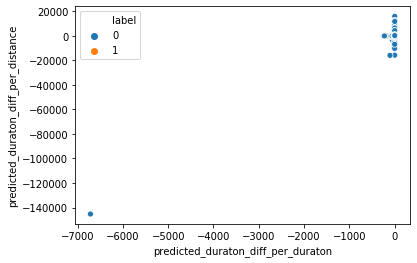

In [148]:
sns.scatterplot(x='predicted_duraton_diff_per_duraton',y='predicted_duraton_diff_per_distance',data=train_df,hue='label')

In [149]:
train_df['predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance'] = train_df['predicted_duraton_diff_per_duraton'] * train_df['predicted_duraton_diff_per_distance']
test_df['predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance'] = test_df['predicted_duraton_diff_per_duraton'] * test_df['predicted_duraton_diff_per_distance']

In [150]:
def normalize_diff(col_name):
    normalizer = StandardScaler()
    normalizer.fit(train_df[train_df['label'] == 1][col_name].values.reshape(-1,1))

    train_df[f'{col_name}_normalized'] = normalizer.transform(train_df[col_name].values.reshape(-1,1))
    test_df[f'{col_name}_normalized'] = normalizer.transform(test_df[col_name].values.reshape(-1,1))

In [151]:
diff_cols = [
    'predicted_fare_diff',
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare', 
    'predicted_fare_diff_per_distance',
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration', 
    'predicted_fare_per_duration_diff',
    'predicted_avg_speed_diff',
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare_diff',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare_diff',
    'predicted_additional_fare_diff_per_additional_fare'
]
for col in diff_cols:
    normalize_diff(col)

### Group by features

In [152]:
train_df.groupby(['pick_cluster']).mean()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_date,pickup_hour,pickup_minute,drop_date,...,predicted_meter_waiting_diff_per_meter_waiting_normalized,predicted_meter_waiting_diff_per_predicted_meter_waiting_normalized,predicted_meter_waiting_per_duration_diff_normalized,predicted_meter_waiting_fare_diff_normalized,predicted_meter_waiting_fare_diff_per_meter_waiting_fare_normalized,predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare_normalized,predicted_meter_waiting_fare_per_meter_waiting_diff_normalized,predicted_meter_waiting_fare_per_duration_diff_normalized,predicted_additional_fare_diff_normalized,predicted_additional_fare_diff_per_additional_fare_normalized
pick_cluster,,,,,,,,,,,,,,,,,,,,,
0,14.694211,1884.382592,737.861307,37.310520,98.280504,315.306287,15.635982,13.604528,29.229528,15.637608,...,0.020787,-0.058176,0.092936,-0.224923,-0.180916,0.014428,-0.055261,-0.196501,0.198651,0.056407
1,15.019556,1120.184806,313.839522,15.648165,125.379855,255.224016,16.339735,14.143833,29.889031,16.341869,...,-0.033783,0.019029,0.075092,0.154408,0.187802,-0.018792,-0.163517,0.274120,0.231927,0.210803
2,11.956081,1649.601351,844.584459,46.841824,143.983108,259.175203,15.543919,14.361486,29.334459,15.557432,...,-0.106213,0.004709,-0.005503,0.160536,0.225957,-0.006852,0.058017,0.227089,-0.044668,0.091998
3,12.599583,1859.699157,747.522023,39.040273,123.316069,348.371407,15.925095,13.882001,29.612153,15.922104,...,-0.158637,0.062790,2.992552,-0.030108,0.036806,-0.005010,-0.052254,6.091732,-0.046380,-0.126966


In [153]:
def mean_value(col):
    grouping_order = ['pick_cluster','pickup_timeslot']
    group = train_df[train_df['label'] == 1].groupby(grouping_order)[col].mean()
    def f(row):
        return group[row['pick_cluster']][row['pickup_timeslot']]
    return f

In [154]:
def mean_encoding(col):
    train_df[f'{col}_mean'] = train_df.apply(mean_value(col),axis=1)
    test_df[f'{col}_mean'] = test_df.apply(mean_value(col),axis=1)
    
    train_df[f'{col}_mean_diff'] = train_df[f'{col}_mean'] - train_df[col]
    test_df[f'{col}_mean_diff'] = test_df[f'{col}_mean'] - test_df[col]

In [155]:
train_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_date,pickup_hour,pickup_minute,drop_date,...,predicted_meter_waiting_diff_per_meter_waiting_normalized,predicted_meter_waiting_diff_per_predicted_meter_waiting_normalized,predicted_meter_waiting_per_duration_diff_normalized,predicted_meter_waiting_fare_diff_normalized,predicted_meter_waiting_fare_diff_per_meter_waiting_fare_normalized,predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare_normalized,predicted_meter_waiting_fare_per_meter_waiting_diff_normalized,predicted_meter_waiting_fare_per_duration_diff_normalized,predicted_additional_fare_diff_normalized,predicted_additional_fare_diff_per_additional_fare_normalized
0,10.5,834.0,56.0,0.000000,64.0,270.32,1,0,20,1,...,0.259635,0.016369,0.077439,0.113176,0.339505,0.072846,0.068194,-0.020752,-0.171147,0.094047
1,10.5,791.0,47.0,0.000000,134.0,197.85,1,0,56,1,...,0.215250,-0.012133,-0.058063,0.098697,0.322392,0.044080,0.045091,-0.004451,-0.167635,0.102711
2,10.5,1087.0,80.0,0.000000,61.0,301.64,1,1,8,1,...,0.261106,0.017758,0.061253,-0.049582,0.147131,0.009760,-0.037367,-0.170535,-0.170411,0.095863
3,10.5,598.0,271.0,15.663800,68.0,82.30,1,2,27,1,...,0.224716,-0.007638,-0.109320,0.306194,0.228187,0.014693,0.041949,0.582851,-0.191838,0.042996
4,10.5,3407.0,182.0,0.000000,112.0,1065.02,1,5,38,1,...,0.265278,0.021934,0.047368,-0.041887,0.156227,0.010123,-0.021826,-0.138794,-0.168989,0.099372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17366,10.5,1292.0,30.0,0.000000,113.0,503.23,24,19,48,24,...,0.171534,-0.026994,-0.038945,0.580032,0.891310,-0.001999,0.389538,0.189691,-0.167660,0.102649
17367,10.5,938.0,314.0,0.000000,41.0,129.78,15,10,17,15,...,0.326163,0.204600,0.945774,-2.087562,-2.261676,0.002131,-0.822988,-2.868650,-0.199631,0.023767
17368,10.5,471.0,19.0,0.000000,239.0,218.51,23,8,28,23,...,0.226661,-0.006635,0.037078,0.359426,0.630562,-0.005376,0.548770,0.296207,-0.172379,0.091006
17369,10.5,840.0,10.0,0.000000,99.0,159.90,26,16,10,26,...,-0.391997,-0.063607,-0.391755,0.339714,0.607263,-0.006031,0.152095,0.403661,-0.159439,0.122935


In [156]:
mean_cols = [
    'fare_per_distance',
    'avg_speed', 
    'meter_waiting_per_duration', 
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'addtional_fare_per_fare',
    'addtional_fare_per_distance', 
    'addtional_fare_per_duration'
]
for col in mean_cols:
    mean_encoding(col)

## Difference binning

In [157]:
cols = [
    'predicted_fare_diff',
    'predicted_duration_diff',
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_fare_diff',
    'predicted_additional_fare_diff',    
]

In [158]:
def col_bucket(column):
    std = train_df[train_df['label']==1][column].std()
    name = f'{column}_bucket'
    train_df[name] = np.round((train_df[column]/std)+1).astype(int)
    test_df[name] = np.round((test_df[column]/std)+1).astype(int)    

In [159]:
for each in cols:
    col_bucket(each)

In [160]:
bin_multiplicatives = {
    'predicted_fare_diff_bucket':[
        'fare',
        'predicted_fare',
        'fare_per_distance',
        'predicted_fare_per_distance',         
    ],
    'predicted_duration_diff_bucket':[
        'duration',
        'predicted_duration',
        'avg_speed', 
        'predicted_avg_speed',         
    ],
    'predicted_meter_waiting_diff_bucket':[
        'meter_waiting', 
        'predicted_meter_waiting', 
        'meter_waiting_per_duration', 
        'predicted_meter_waiting_per_duration',
    ],
    'predicted_meter_waiting_fare_diff_bucket':[
        'meter_waiting_fare',
        'predicted_meter_waiting_fare',
        'meter_waiting_fare_per_meter_waiting',
        'predicted_meter_waiting_fare_per_meter_waiting',
        'meter_waiting_fare_per_duration',
        'predicted_meter_waiting_fare_per_duration',
    ],
    'predicted_additional_fare_diff':[
        'additional_fare',
        'predicted_additional_fare', 
        'predicted_addtional_fare_per_fare', 
        'addtional_fare_per_fare',
        'addtional_fare_per_distance', 
        'predicted_addtional_fare_per_distance',
        'addtional_fare_per_duration', 
        'predicted_addtional_fare_per_duration',
    ]
    
}

In [161]:
for bucket in tqdm(bin_multiplicatives):
    for col in bin_multiplicatives[bucket]:
        name = f'{bucket}@{col}'
        train_df[name] = train_df[bucket] * train_df[col]
        test_df[name] = test_df[bucket] * test_df[col]

100%|██████████| 5/5 [00:00<00:00, 103.04it/s]


In [162]:
train_df.to_csv('train_df_final_blanced.csv',index=False)
test_df.to_csv('test_df_final_blanced.csv',index=False)

# Classifier

In [163]:
train_df = pd.read_csv('train_df_final_blanced.csv')
test_df = pd.read_csv('test_df_final_blanced.csv')

features = [
#     'additional_fare', 
#     'pickup_date', 
#     'pickup_hour',
#     'pickup_minute', 
#     'drop_date', 
#     'drop_hour', 
#     'drop_minute',    
#     'pick_cluster', 
#     'is_more_than_one_day', 
#     'distance_km', 
#     'pickup_timeslot', 
#     'day_of_week', 
#     'is_weekday', 
#     'cal_time_difference',
    # noise columns    
    'meter_waiting', 
    'meter_waiting_fare',
    'fare',
    'predicted_fare',
    'fare_per_distance',
    'predicted_fare_per_distance', 
    'predicted_duration',
    'fare_per_duration',
    'predicted_fare_per_duration',
    'avg_speed', 
    'predicted_avg_speed', 
    'predicted_meter_waiting', 
    'meter_waiting_per_duration', 
    'predicted_meter_waiting_per_duration',
    'predicted_meter_waiting_fare',
    'meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration',
    'predicted_additional_fare', 
    'predicted_addtional_fare_per_fare', 
    'addtional_fare_per_fare',
    'addtional_fare_per_distance', 
    'predicted_addtional_fare_per_distance',
    'addtional_fare_per_duration', 
    'predicted_addtional_fare_per_duration',
    'predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance',
    'predicted_fare_diff_normalized',
    'predicted_fare_diff_per_fare_normalized',
    'predicted_fare_diff_per_predicted_fare_normalized', 
    'predicted_fare_diff_per_distance_normalized',
    'predicted_duraton_diff_per_duraton_normalized',
    'predicted_duraton_diff_per_predicted_duration_normalized', 
    'predicted_fare_per_duration_diff_normalized',
    'predicted_avg_speed_diff_normalized',
    'predicted_meter_waiting_diff_normalized',
    'predicted_meter_waiting_diff_per_meter_waiting_normalized',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting_normalized',
    'predicted_meter_waiting_per_duration_diff_normalized',
    'predicted_meter_waiting_fare_diff_normalized',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_per_meter_waiting_diff_normalized',
    'predicted_meter_waiting_fare_per_duration_diff_normalized',
    'predicted_additional_fare_diff_normalized',
    'predicted_additional_fare_diff_per_additional_fare_normalized',
    
#     'fare_per_distance_mean',
#     'avg_speed_mean', 
#     'meter_waiting_per_duration_mean', 
#     'meter_waiting_fare_per_meter_waiting_mean',
#     'meter_waiting_fare_per_duration_mean',
#     'addtional_fare_per_fare_mean',
#     'addtional_fare_per_distance_mean', 
#     'addtional_fare_per_duration_mean', 

#     'fare_per_distance_mean_diff',
#     'avg_speed_mean_diff', 
#     'meter_waiting_per_duration_mean_diff', 
#     'meter_waiting_fare_per_meter_waiting_mean_diff',
#     'meter_waiting_fare_per_duration_mean_diff',
#     'addtional_fare_per_fare_mean_diff',
#     'addtional_fare_per_distance_mean_diff', 
#     'addtional_fare_per_duration_mean_diff'
    'predicted_fare_diff_bucket',
    'predicted_duration_diff_bucket',   
    'predicted_meter_waiting_diff_bucket',
    'predicted_meter_waiting_fare_diff_bucket',
    'predicted_additional_fare_diff_bucket',
    'predicted_fare_diff_bucket@fare',
    'predicted_fare_diff_bucket@predicted_fare',
    'predicted_fare_diff_bucket@fare_per_distance',
    'predicted_fare_diff_bucket@predicted_fare_per_distance',
    'predicted_duration_diff_bucket@duration',
    'predicted_duration_diff_bucket@predicted_duration',
    'predicted_duration_diff_bucket@avg_speed',
    'predicted_duration_diff_bucket@predicted_avg_speed',
    'predicted_meter_waiting_diff_bucket@meter_waiting',
    'predicted_meter_waiting_diff_bucket@predicted_meter_waiting',
    'predicted_meter_waiting_diff_bucket@meter_waiting_per_duration',
    'predicted_meter_waiting_diff_bucket@predicted_meter_waiting_per_duration',
    'predicted_meter_waiting_fare_diff_bucket@meter_waiting_fare',
    'predicted_meter_waiting_fare_diff_bucket@predicted_meter_waiting_fare',
    'predicted_meter_waiting_fare_diff_bucket@meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_diff_bucket@predicted_meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_diff_bucket@meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_diff_bucket@predicted_meter_waiting_fare_per_duration',
    'predicted_additional_fare_diff@additional_fare',
    'predicted_additional_fare_diff@predicted_additional_fare',
    'predicted_additional_fare_diff@predicted_addtional_fare_per_fare',
    'predicted_additional_fare_diff@addtional_fare_per_fare',
    'predicted_additional_fare_diff@addtional_fare_per_distance',
    'predicted_additional_fare_diff@predicted_addtional_fare_per_distance',
    'predicted_additional_fare_diff@addtional_fare_per_duration',
    'predicted_additional_fare_diff@predicted_addtional_fare_per_duration'
]

In [ ]:
cat_features = [
    'predicted_fare_diff_bucket',
    'predicted_duration_diff_bucket',
    'predicted_meter_waiting_diff_bucket',
    'predicted_meter_waiting_fare_diff_bucket',
    'predicted_additional_fare_diff_bucket',
]

In [ ]:
labels = train_df['label'].values
train_df = train_df.drop(['label'], axis=1)[features]

In [ ]:
class_weights = [(labels.shape[0] - np.sum(labels)) / np.sum(labels),1]

In [ ]:
params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
#     'class_weights':class_weights,
    'border_count':512,
#     'depth':6,
}

In [320]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
train_df_pool = Pool(data=train_df[features], cat_features=cat_features)

In [321]:
skf = StratifiedKFold(n_splits=3)

validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
for train_index, test_index in skf.split(train_df, labels):
    X_train, X_test = train_df.iloc[train_index,:], train_df.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))

Learning rate set to 0.058029
0:	learn: 0.9620894	test: 0.9671217	best: 0.9671217 (0)	total: 24.8ms	remaining: 24.8s
10:	learn: 0.9700490	test: 0.9744128	best: 0.9744128 (10)	total: 169ms	remaining: 15.2s
20:	learn: 0.9717611	test: 0.9756098	best: 0.9756098 (20)	total: 319ms	remaining: 14.9s
30:	learn: 0.9733786	test: 0.9754883	best: 0.9756098 (20)	total: 457ms	remaining: 14.3s
40:	learn: 0.9732314	test: 0.9754977	best: 0.9756098 (20)	total: 607ms	remaining: 14.2s
50:	learn: 0.9739837	test: 0.9758621	best: 0.9759694 (46)	total: 742ms	remaining: 13.8s
60:	learn: 0.9748744	test: 0.9760353	best: 0.9761380 (56)	total: 926ms	remaining: 14.3s
70:	learn: 0.9760697	test: 0.9760261	best: 0.9761380 (56)	total: 1.07s	remaining: 14s
80:	learn: 0.9767331	test: 0.9758157	best: 0.9761380 (56)	total: 1.24s	remaining: 14.1s
90:	learn: 0.9769669	test: 0.9758204	best: 0.9761380 (56)	total: 1.38s	remaining: 13.8s
100:	learn: 0.9774818	test: 0.9761014	best: 0.9761950 (94)	total: 1.53s	remaining: 13.6s
110:

In [322]:
np.mean(validation_scores), np.std(validation_scores), np.min(validation_scores)

(0.9542914496090901, 0.0031124104041211193, 0.9500863557858377)

In [15]:
submission_df['prediction'] = np.where(submission_preds > 2, 1, 0)
submission_df.to_csv('submission.csv',index=False)

In [430]:
best_model = models[np.argmax(validation_scores)]

In [431]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,predicted_fare_diff_per_distance_normalized,8.806101
1,fare_per_distance,8.191200
2,predicted_fare_diff_per_predicted_fare_normalized,6.385269
3,predicted_duraton_diff_per_duraton@predicted_d...,4.751917
4,predicted_additional_fare_diff_normalized,4.663147
5,predicted_fare_diff_normalized,4.570452
6,predicted_fare_per_distance,4.184867
7,predicted_additional_fare_diff_per_additional_...,3.624173
8,fare_per_duration,3.033967
9,predicted_fare_diff_per_fare_normalized,2.909325


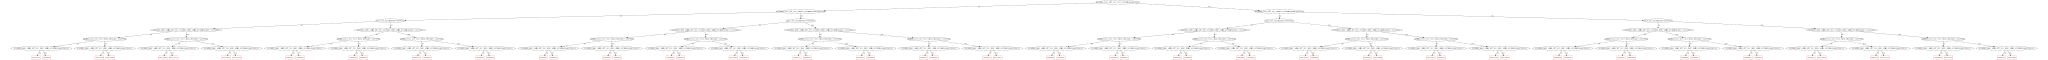

In [415]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

In [416]:
worst_model = models[np.argmin(validation_scores)]

In [417]:
worst_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,predicted_fare_diff_per_predicted_fare_normalized,11.262931
1,predicted_duraton_diff_per_duraton@predicted_d...,9.561961
2,predicted_fare_diff_per_distance_normalized,7.274241
3,predicted_fare_diff_normalized,5.764607
4,fare_per_duration,4.895544
5,predicted_additional_fare_diff_per_additional_...,4.531051
6,fare_per_distance,4.129538
7,predicted_fare_per_distance,3.648430
8,predicted_additional_fare_diff_normalized,2.683112
9,fare_per_distance_mean_diff,2.538554


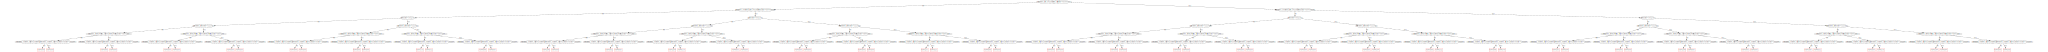

In [285]:
worst_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

In [286]:
cv_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'verbose': False
}

In [ ]:
cv_pool = Pool(data=train_df,label=labels)

In [ ]:
scores = cv(cv_pool,cv_params,plot=True, fold_count=3)

In [ ]:
def filter_features(features):
    features_to_drop = []
    features_to_keep = []
    for feature in features:
        if feature in features_to_drop:
            continue
        highly_corr_features = list((np.array(features))[np.abs(train_df[features].corr()[feature]) > 0.8])
        for each in highly_corr_features:
            if each == feature or each in features_to_keep:
                continue
            else:
                features_to_drop.append(each)
        features_to_keep.append(feature)
    return features_to_keep

In [ ]:
f = list(best_model.get_feature_importance(prettified=True)['Feature Id'].values)
new_features = filter_features(f)

In [ ]:
sns.heatmap(train_df[new_features].corr())

In [ ]:
train_df = train_df[new_features]

In [ ]:
submission_pool = Pool(data=test_df[new_features])

In [ ]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_pools = []
models = []
for train_index, test_index in skf.split(train_df, labels):
    X_train, X_test = train_df.iloc[train_index,:], train_df.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train)
    test_pool = Pool(data=X_test, label=y_test)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)
    train_preds += model.predict_proba(train_df_pool)[:,1]
    test_preds += model.predict_proba(submission_pool)[:,1]

In [ ]:
np.mean(validation_scores), np.std(validation_scores)

In [ ]:
stacking_train_df['catboost_low_corr'] = train_preds

stacking_test_df['catboost_low_corr'] = submission_preds

In [ ]:
submission_df['prediction'] = np.where(submission_preds > 2, 1, 0)
submission_df.to_csv('submission_filtered.csv',index=False)

In [ ]:
best_model = models[np.argmax(validation_scores)]

In [ ]:
best_model.get_feature_importance(prettified=True)

In [ ]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

In [ ]:
cv_pool = Pool(data=train_df,label=labels)

In [ ]:
scores = cv(cv_pool,cv_params,plot=True, fold_count=3)